The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


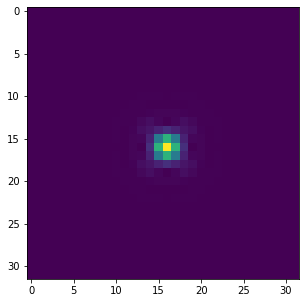

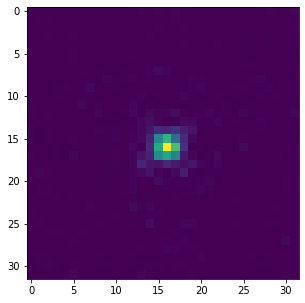

In [9]:
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [5, 5]
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration
import matplotlib.pyplot as plt
import numpy as np

from data.visualise import show_psf_axial, grid_psfs
from data.align_psfs import align_psfs, tf_find_optimal_roll, mask_img_stack, norm_zero_one

align_psfs.debug = False

kwargs = dict(
    wl=647,
    na=1.3,
    ni=1.51,
    res=106,
    zres=10,
    size=32,
    zsize=400,
    vec_corr="none",
    condition="none",
)
psf = HanserPSF(**kwargs)
psf = apply_aberration(psf, np.array([0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 1]))

blank_psf = psf.PSFi

blank_psf = norm_zero_one(blank_psf) * 255

from experiments.noise.noise_psf import EMCCD
import matplotlib.pyplot as plt
import numpy as np

e = EMCCD()
e.add_noise(np.random.randint(0, 255, size=(32,32)))

psf = blank_psf[200]
plt.imshow(psf)
plt.show()
plt.imshow(e.add_noise(psf))
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


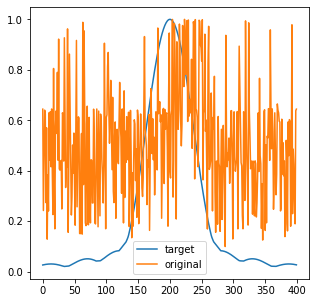

offsets [100, 75.0]
[1000 1010 1020 1030 1040]
[750. 760. 770. 780. 790.]


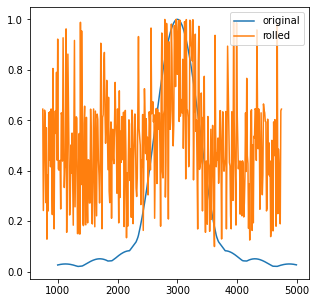

In [214]:


offset = 25
rolled_psf = np.roll(blank_psf, offset, axis=0)

rolled_psf += np.random.normal(0, 3e-1, size=rolled_psf.shape)
from skimage.exposure import match_histograms
rolled_psf = match_histograms(rolled_psf, blank_psf)

psfs = np.stack((blank_psf, rolled_psf))
plt.plot(psfs[0].max(axis=(1,2)), label='target')
plt.plot(psfs[1].max(axis=(1,2)), label='original')
plt.legend()
plt.show()

res = tf_find_optimal_roll(rolled_psf, blank_psf, 1)
print('offsets', offsets)
assert res == offset

imgs = np.concatenate(psfs)
zs = []
labels = ['original', 'rolled']
offsets = [100, 100-res]
for i, o in enumerate(offsets):
    vals = (np.arange(0, psfs[0].shape[0])*10) + (o*10)
    print(vals[0:5])
    plt.plot(vals, np.max(psfs[i], axis=(1,2)), label=labels[i])
plt.legend()
plt.show()



In [ ]:
import h5py

def read_spots(dirpath):
    f = h5py.File(dirpath, 'r')
    spots = np.array(f['spots'])[:, :, :, np.newaxis]
    f.close()
    return spots

dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_pairs/grid_pairs_spots.hdf5'
test_spots = read_spots(dirpath)

dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_test/training/NPC-A647-3D-BEADS/0021_spots.hdf5'

train_spots = read_spots(dirpath)

print(train_spots.shape)
print(test_spots.shape)
for spots in [train_spots, test_spots]:
    print(spots.min(), spots.mean(), spots.std(), spots.max())

In [ ]:
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

plt.rcParams['figure.figsize'] = [3, 3]
train_spot = train_spots[0]

mean_img = np.mean(train_spots, axis=0)

plt.imshow(train_spot)
plt.show()
plt.imshow(mean_img)
plt.show()
plt.imshow(match_histograms(train_spot, mean_img))
plt.show()

print(train_spot.min(), train_spot.max())

print(mean_img.min(), mean_img.max())

print(match_histograms(train_spot, mean_img).min(), match_histograms(train_spot, mean_img).max())

In [ ]:
import numpy as np
from skimage.exposure import equalize_hist
plt.rcParams['figure.figsize'] = [5,5]

mean_img = np.mean(train_spots, axis=0)

for i in range(0, 10):
    show_imgs(train_spots[i], match_histograms(train_spots[i], mean_img))

Debug enabled in datasets.py
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'bpath': PosixPath('/home/miguel/Projects/uni/data/smlm_3d/picasso_test/training/NPC-A647-3D-BEADS'), 'img': '../NPC-A647-3D-BEADS-as-stacks.tif', 'frame': '0021.tif', 'locs': '0021_locs.hdf5', 'locs_yaml': '0021_locs.yaml', 'spots': '0021_spots.hdf5', 'voxel_sizes': (50, 106, 106)}
Loaded spots...
Converted coords...
Aligning (5, 41, 31, 31) psfs...


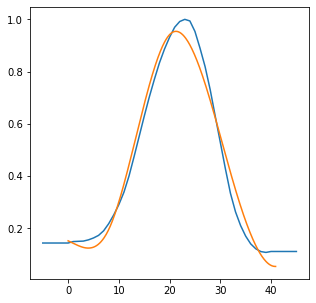

  0%|          | 0/4 [00:00<?, ?it/s]

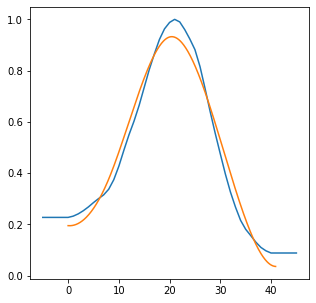

 25%|██▌       | 1/4 [00:00<00:00,  4.06it/s]

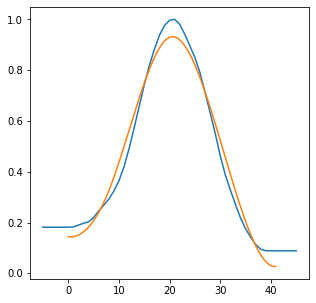

 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

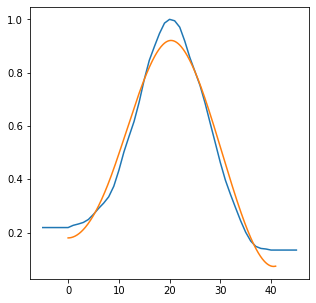

 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

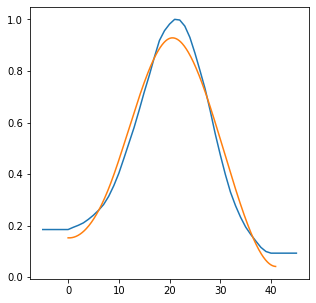

100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

Prepared stacks...
masking
195 464
195 450
1 195 450
Normalising psfs...
-1.0 1.0
train
Imgs, 	(143, 31, 31, 1)
		-1.0, 1.0
Coords, 	(143, 2)
Z coords	(143,)
val
Imgs, 	(41, 31, 31, 1)
		-1.0, 1.0
Coords, 	(41, 2)
Z coords	(41,)
test
Imgs, 	(21, 31, 31, 1)
		-1.0, 1.0
Coords, 	(21, 2)
Z coords	(21,)
-1.0 1.0


In [14]:
%load_ext autoreload
%autoreload 2
from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs

cfg = dataset_configs['picasso_test']['training']
print(cfg)

ds = TrainingPicassoDataset(cfg)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

radius = 107
n_elements = 8
z_depths = [0, 200]
offset = (0, 0)

angles = [i*((np.pi*2)/n_elements) for i in range(n_elements)]
x = np.array([np.cos(a)*radius for a in angles])
y = np.array([np.sin(a)*radius for a in angles])

x += offset[0]
y += offset[0]

xs = [round(n, 3) for n in np.concatenate((x, x))]
ys = [round(n, 3) for n in np.concatenate((y, y))]
zs = [round(n, 3) for n in (sorted(z_depths*n_elements))]

print(len(xs), len(ys), len(zs))

plt.scatter(xs, ys)
plt.show()

print(xs)
print(ys)
print(zs)

In [ ]:
dataset ='picasso_test'
BOUND = 31
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers as Layers
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1, name='ResBlock'):
        super(ResBlock, self).__init__(name=name)
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1

def resnet_model(bound=BOUND):
    print(f'Loading functional resnet with bound {bound}')
    img_input = Input((bound, bound, 1))
    coords_input = Input((2,))
    
#     augment_data = Sequential([
#         RandomTranslation(1/bound, 1/bound)
#     ])
    
    feature_extraction = Sequential([
        Conv2D(64, 7, 2, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(3, 2),
        ResBlock(64, name='ResBlock64_1'),
        ResBlock(64, name='ResBlock64_2'),
        ResBlock(64, name='ResBlock64_3'),
        ResBlock(128, 2, name='ResBlock128_1'),
        ResBlock(128, name='ResBlock128_2'),
        ResBlock(128, name='ResBlock128_3'),
        ResBlock(128, name='ResBlock128_4'),
        ResBlock(256, 2, name='ResBlock256_1'),
        ResBlock(256, name='ResBlock256_2'),
        ResBlock(256, name='ResBlock256_3'),
        ResBlock(256, name='ResBlock256_4'),
        ResBlock(256, name='ResBlock256_5'),
        ResBlock(256, name='ResBlock256_6'),
        ResBlock(512, 2, name='ResBlock512_1'),
        ResBlock(512, name='ResBlock512_2'),
        ResBlock(512, name='ResBlock512_3'),
        GlobalAveragePooling2D()
    ])
    
    mlp = Sequential([
        Dense(1024),
        Dropout(0.5),
        Dense(1024),
        Dropout(0.5),
        Dense(1)
    ])
    
#     x = augment_data(img_input)
    x = feature_extraction(img_input)
    x = tf.concat((x, coords_input), axis=1)
    x = mlp(x)
    
    return Model(inputs=(img_input, coords_input), outputs=x)
    
    

import os
version = ''
if version is not None:
    model_name = f'{dataset}'
model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', f'{dataset}{version}')

def load_model():
    print('Loading model...')
    print(model_path)
    model = resnet_model(BOUND)
    model.load_weights(model_path)
    return model


model = load_model()


In [ ]:
model.summary()

In [ ]:
'''
--------
|    x |   <- 50nm deeper than other
|      |
| x    |
--------

5 structures, frame 16 px,
structureX: 1000,3000
structureY: 1000,3000

structure3D: 0,50
ExchangeLabels:1,1
'''

dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_single/grid_single'
# dirpath = '/home/miguel/Projects/uni/data/smlm_3d/picasso_sim/grid_pairs/grid_pairs'

In [ ]:
import yaml

yaml_file = f'{dirpath}.yaml'

class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

with open(yaml_file, "r") as stream:
    root = yaml.load(stream, Loader=SafeLoaderIgnoreUnknown)
with open(yaml_file, "w") as stream:
    yaml.dump(root, stream)

In [ ]:
%load_ext autoreload
%autoreload 2

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [5,5]

def norm_zero_one(img):
    img_max = img.max()
    img_min = img.min()
    return (img - img_min) / (img_max - img_min)

def norm_one_one(img):
    return (2 * norm_zero_one(img)) - 1 

locs = f'{dirpath}_locs.hdf5'
spots = f'{dirpath}_spots.hdf5'
print(locs)
print(spots)
df = pd.read_hdf(locs, 'locs')

f = h5py.File(spots, 'r')
spots = np.array(f['spots'])[:, :, :, np.newaxis]

df['id'] = np.arange(0, df.shape[0])
print(spots.shape)
print(df.shape, spots.shape)
f.close()

from data.visualise import grid_psfs
# plt.imshow(grid_psfs(spots.squeeze()))
# plt.show()

assert df.shape[0] == spots.shape[0]



from data.datasets import norm_dataset_from_config, standardise, load_ref_img_and_norm

print(spots.shape)
print(spots.min(), spots.max())
# spots = standardise(spots)
# spots = load_ref_img_and_norm(spots)
for s in spots[0:5]:
    print(s.min(), s.max())
    
spots = np.stack([norm_one_one(img) for img in spots])

print(spots.min(), spots.max())



In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(grid_psfs(spots[0:50].squeeze()).squeeze())
plt.show()

mean_img = spots[1]

spots_matched_hist = np.stack([match_histograms(img, mean_img) for img in spots])
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(mean_img)
plt.show()
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(grid_psfs(spots_matched_hist[0:50].squeeze()).squeeze())
plt.show()


In [ ]:
# # Rescale to [-1, 1]
# spots = np.stack([norm_one_one(img) for img in spots])


plt.gca().invert_yaxis()

df['index'] = np.arange(0, df.shape[0])
print(spots.shape)
plt.rcParams['figure.figsize'] = [5, 5]
sns.scatterplot(data=df, x='x', y='y', marker='+')
plt.show()


coords = np.zeros((spots.shape[0], 2))

pred = model.predict((spots_matched_hist, coords)).squeeze()
print(np.std(pred))
df['pred'] = pred
print(pred.min(), pred.max())

plt.rcParams['figure.figsize'] = [5, 5]
sns.histplot(pred, bins=50)
plt.xlabel('Z position (nm)')
plt.show()


sub_imgs = spots[0:100]
sub_preds = pred[0:100]
plt.rcParams['figure.figsize'] = [100, 100]
from data.visualise import grid_psfs
print(np.sort(sub_preds.squeeze()))

plt.imshow(grid_psfs(sub_imgs[np.argsort(sub_preds.squeeze())].squeeze()))
plt.show()

In [ ]:
print(np.std(pred))

In [ ]:
%load_ext autoreload
%autoreload 2

from config.datasets import dataset_configs

from data.datasets import TrainingDataSet, ExperimentalDataSet, GenericDataSet, MultiTrainingDataset, TrainingPicassoDataset

dataset = 'picasso_test'
version = ''
cfg = dataset_configs[dataset]['training']
print(cfg)

train_dataset = TrainingPicassoDataset(cfg)

In [ ]:
train_dataset.data['train'][0][0].max()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

test_imgs = spots.flatten()

plt.hist(test_imgs, label='exp', alpha=0.5)

for k in train_dataset.data.keys():
    imgs = train_dataset.data[k][0][0].flatten()
    print(imgs.min(), imgs.max())
    plt.hist(imgs.flatten(), label=k, alpha=0.5)

plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
mean_pixel_vals = np.mean(spots, axis=(1,2))
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(mean_pixel_vals, pred)
plt.xlabel('Mean pixel value')
plt.ylabel('Pred')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
# df['emitter'] = df['x'] < 60
df['pred'] = pred.squeeze()
# df['pred2'] = df['pred']>-250
df['snr'] = [np.max(s)/np.median(s) for s in spots]
df['error'] = df['pred']+130
sns.scatterplot(data=df, x='snr', y='pred')
plt.show()
sns.scatterplot(data=df, x='snr', y='error')
plt.show()
# sns.histplot(daata=df, x='pred', hue='emitter')
# plt.show()

# sns.scatterplot(data=df, x='x', y='y', hue='pred2')
# plt.show()



In [ ]:
"""
Checks influence of polar coords on Z localisation
"""

# from itertools import product

# plt.rcParams['figure.figsize'] = [5, 5]

# spot = spots[0:1][:, :, :, np.newaxis]
# thetas = np.linspace(0, 1, 20)
# rhos = np.linspace(0, 1, 20)

# coords = np.array(list(product(thetas, rhos))).squeeze()
# spot = np.repeat(spot, coords.shape[0], axis=0)

# preds = model.predict((spot, coords))

# tmp_df = pd.DataFrame.from_dict({'theta': coords[:, 0], 'rho': coords[:, 1], 'z': preds.squeeze()})
# sns.scatterplot(data=tmp_df, x='theta', y='z')
# plt.show()
# sns.scatterplot(data=tmp_df, x='rho', y='z')
# plt.show()
# sns.scatterplot(data=tmp_df, x='theta', y='rho', hue='z')
# plt.show()

In [ ]:
# %load_ext autoreload
# %autoreload 2
# from config.datasets import dataset_configs
# from data.datasets import StormDataset, ExperimentalDataSet
# import seaborn as sns
# import matplotlib.pyplot as plt

# dataset ='picasso_test'

# cfg = dataset_configs[dataset]['nucleopore']
# ds = StormDataset(cfg, normalize_psf=True, lazy=True, apply_clustering=False)
# # ds.neighbour_radius = 15
# # ds.max_off_frames = 1000
# ds.csv_data = ds.csv_data[(ds.csv_data['x [nm]'] > 8250) 
#                           & (ds.csv_data['x [nm]'] < 8425) 
#                           & (ds.csv_data['y [nm]'] > 9425) 
#                           & (ds.csv_data['y [nm]'] < 9575) 
#                          ]

# plt.rcParams['figure.figsize'] = [5, 5]
# sns.scatterplot(data=ds.csv_data, x='x [nm]', y='y [nm]', marker='.')
# plt.show()


# ds.prepare_data()

# from scipy.ndimage import median_filter
# ds.data[0] = np.stack([median_filter(d, size=2) for d in ds.data[0]])

# df = ds.csv_data
# print(df.shape)
# print(ds.data[0].shape)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

plt.rcParams['figure.figsize'] = [5,5]

coords = df[['x', 'y']].to_numpy() * 100
distance_matrix = euclidean_distances(coords, coords)
eps = 15
min_count = 50

distance_matrix = (distance_matrix < eps).astype(int).sum(axis=0)
idx = np.argwhere(distance_matrix > min_count).squeeze()
sub_coords = coords[idx]
print(coords.shape)
print(sub_coords.shape)

cluster_ids = DBSCAN(eps=eps, min_samples=min_count).fit_predict(sub_coords)
sns.scatterplot(x=sub_coords[:, 0], y=sub_coords[:, 1], hue=cluster_ids.astype(str))
plt.axis('equal')
plt.show()

sub_df = df.iloc[idx]
sub_df['cluster_id'] = cluster_ids.squeeze().astype(str)
sub_spots = spots[idx]


In [ ]:
sns.histplot(model.predict((spots, np.zeros((spots.shape[0], 2)))).squeeze())
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from data.visualise import grid_psfs

plt.rcParams['figure.figsize'] = [20, 5]
# df['cluster_id'] = OPTICS().fit_predict(df[['x', 'y']].to_numpy()).squeeze().astype(str)
plt.axis('equal')
plt.title('Units: pixels (90nm each)')
sns.scatterplot(data=sub_df, x='x', y='y', marker='.', hue='cluster_id', legend=False)
plt.show()

n_components = 2

gm_mean_diffs = {}
mean_img_diffs = {}


def gm_min_bic(data, imgs):
    gm_df = pd.DataFrame({'pred': data.squeeze()}, index=np.arange(0, data.squeeze().shape[0]))

    best_gm = None
    min_bic = np.inf
    bics = []
    cov_type = 'tied'
    stdevs = []
    
    fig, axes = plt.subplots(1, 6)
    for n in range(1, 7):
        gm = GaussianMixture(n_components=n, n_init=20, covariance_type=cov_type).fit(data)
        bic = gm.bic(data)
        
        bics.append(round(bic, 3))
        stdevs.append(round(np.std(gm.weights_), 3))
        if bic < min_bic:
            min_bic = bic
            best_gm = gm
        
        ax = axes[n-1]
        labels = gm.predict(data).squeeze()

        gm_df['cluster_id'] = labels.astype(str)

        weights = gm.weights_

        sns.histplot(data=gm_df, x='pred', hue='cluster_id', stat='density', alpha=0.2, bins=20, ax=ax)

        # create necessary things to plot
        x_axis = np.linspace(data.min(), data.max(), 50)
        ys = []
        sub_df2 = pd.DataFrame.from_dict({'x': x_axis})
        for i in range(0, best_gm.n_components):
            if cov_type == 'tied':
                cov = gm.covariances_.squeeze()
            elif cov_type == 'full' or cov_type == None:
                cov = gm.covariances_[i][0][0]
            elif cov_type == 'spherical':
                cov = gm.covariances_[i]
            elif cov_type == 'diag':
                cov_type = gm.covariances_[i]

            sub_df2[f'y_{i}'] = norm.pdf(x_axis, float(gm.means_[i][0]), np.sqrt(cov))*gm.weights_[i]
            sns.lineplot(data=sub_df2, x='x', y=f'y_{i}', ax=ax)
    plt.show()        
        
    print(bics)
    print(stdevs)

    return best_gm.means_[:, 0]

def apply_gm(data, imgs, cid):
    data = data.reshape(-1, 1)
    gm_df = pd.DataFrame({'pred': list(data)})
    
    return gm_min_bic(data, imgs)
    

all_coords = []
for cid in set(sub_df['cluster_id']):
    if cid == '-1':
        continue
    idx = np.argwhere(sub_df['cluster_id'].to_numpy()==cid).squeeze()
    imgs = sub_spots[idx][:, :, :, np.newaxis]
    coords = np.zeros((imgs.shape[0], 2))
    preds = model.predict((imgs, coords)).squeeze()
    preds -= preds.min()
    preds += 0.00000001
    preds = np.sqrt(preds)
    z_pos = apply_gm(preds, imgs, cid)
    x, y = sub_df.iloc[idx][['x', 'y']].mean(axis=0).to_numpy() * 106
    coords = [[x, y, z, int(cid)] for z in z_pos]
    all_coords.extend(coords)

all_coords = np.array(all_coords)
res = pd.DataFrame.from_dict({
    k: all_coords[:, i] for k, i in zip(['x', 'y', 'z', 'cluster_id'], [0, 1, 2, 3])
})


In [ ]:
d = gm_mean_diffs
tops = [np.max(v) for k, v in d.items()]
bottoms = [np.min(v) for k, v in d.items()]
print(np.mean(tops))
print(np.mean(bottoms))
print(np.mean(tops) - np.mean(bottoms))

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
res['cluster_id'] = res['cluster_id'].astype(int)
fig = plt.figure()
fig.tight_layout() 

plt.subplots_adjust(wspace = 0.4) 
ax = fig.add_subplot(121, projection='3d')

ax.scatter(res['x'], res['y'], res['z'], marker='o', c=res['cluster_id'])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax2 = fig.add_subplot(122)

ax2.scatter(res['cluster_id'], res['z'], c=res['cluster_id'])
plt.xlabel('Cluster ID')
plt.title('All units in nm')
plt.show()

In [ ]:
print(spots.shape)
print(coords.shape)
all_coords = np.zeros((spots.shape[0], 2))
all_spots = spots[:, :, :, np.newaxis]

pred = model.predict((all_spots, all_coords))
df['z'] = pred.squeeze()
# for c in list(df):
#     sns.scatterplot(data=df, x=c, y='z')
#     plt.show()
sns.scatterplot(data=df.iloc[0:1000], x='frame', y='z')
plt.show()
sns.histplot(data=df, x='z')
plt.show()

In [ ]:

best_img = spots[0]

recs = []

imgs = []
coords = []

for _ in range(1000):
    noise_loc = np.random.uniform(0, 0.8)
    noise_scale = np.random.uniform(0, 0.7)
    new_img = np.random.normal(loc=noise_loc, scale=noise_scale, size=best_img.shape)
    new_img += best_img
    new_img = norm_zero_one(new_img)
    
    new_img = norm_zero_one(new_img)
    
    new_img = np.array([new_img])
    imgs.append(new_img)
    coords.append(np.zeros((1, 2)))
    
    recs.append({
        'img_mean': np.mean(new_img),
        'img_median': np.median(new_img),
        'noise_loc': noise_loc,
        'noise_scale': noise_scale,
    })

df = pd.DataFrame.from_dict(recs)

imgs = np.concatenate(imgs)
print(imgs.shape)
coords = np.concatenate(coords)
print(coords.shape)
pred = model.predict((imgs, coords)).squeeze()
err = pred
df['err'] = err
df['pred'] = pred
for col in list(df):
    sns.scatterplot(data=df, x=col, y='err')
    plt.show()
sns.scatterplot(data=df, x='noise_loc', y='noise_scale', hue='err')
plt.show()
